In [2]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
# using Interpolations
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

In [3]:
params = Knet.params
# param = Knet.param
# param0 = Knet.param0

params (generic function with 2 methods)

In [4]:
function resize_gray_image_tensor(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

function resize_MNIST(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img'), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

resize_MNIST (generic function with 3 methods)

In [5]:
xtrn,_ = MNIST.traindata()
xtst,_ = MNIST.testdata()
xtrn = Array{Float64, 3}(xtrn)
xtst = Array{Float64, 3}(xtst)

xtrn = resize_MNIST(xtrn, 32/28)
xtst = resize_MNIST(xtst, 32/28)

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, 1,:), xtype = array_type)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, 1,:), xtype = array_type);

,,,,,,,,,

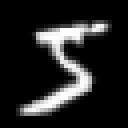
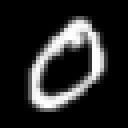
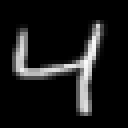
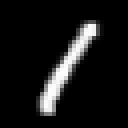
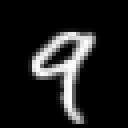
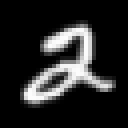
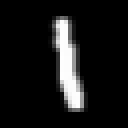
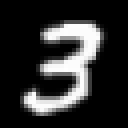
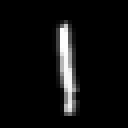
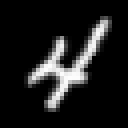

In [6]:
k = 1:10
[Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]

In [7]:
nz = 32
ngf = 16
nc = 1

# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end

(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)

# Activation Layer
mutable struct Activation; f; end;

(a::Activation)(x) = a.f.(x)

# 2D Batch Normalization
mutable struct BatchNorm
    moments
    params
    nParameters
end

(b::BatchNorm)(x) = batchnorm(x, b.moments, b.params)

BatchNorm(C) = BatchNorm(bnmoments(), array_type(bnparams(C)), 0)

moments = bnmoments(momentum = 0.1)

# Define a convolutional layer:
struct Conv; w; b; f; p; stride; padding; end

Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=identity; pdrop=0, stride = 1, padding = 0) = 
Conv(param(rand(Uniform(-sqrt(1/(cx * w1 * w2)),sqrt(1/(cx * w1 * w2))), w1,w2,cx,cy)), 
param(rand(Uniform(-sqrt(1/(cx * w1 * w2)),sqrt(1/(cx * w1 * w2))), 1,1,cy,1)), f, pdrop, stride, padding)

(c::Conv)(x) = (conv4(c.w, dropout(x,c.p), padding = c.padding, stride = c.stride, mode = 1) .+ c.b)

# Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)


# Transposed Convolution Definition
struct DeConv; w; b; f; p; stride; padding; end

DeConv(w1::Int, w2::Int, cx::Int, cy::Int, f = identity; pdrop = 0, stride = 1, padding = 0) = 
DeConv(param(rand(Uniform(-sqrt(1/(cy * w1 * w2)),sqrt(1/(cy * w1 * w2))), w1,w2,cy,cx)), 
    param(rand(Uniform(-sqrt(1/(cy * w1 * w2)),sqrt(1/(cy * w1 * w2))), 1,1,cy,1)), f, pdrop, stride, padding)

(dc::DeConv)(x) = (deconv4(dc.w, dropout(x, dc.p), padding = dc.padding, stride = dc.stride, mode = 1) .+ dc.b)


# Encoder and Decoder Definitions
latent_dim = 32
Encoder = Chain(Conv(4,4, nc, ngf, stride = 2, padding = 1),
                BatchNorm(ngf),
                Activation(Knet.elu),
                Conv(4, 4, ngf, ngf * 2, stride = 2, padding = 1),
                BatchNorm(ngf * 2),
                Activation(Knet.elu),
                Conv(4, 4, ngf * 2, ngf * 4, stride = 2, padding = 1),
                BatchNorm(ngf * 4),
                Activation(Knet.elu),
                Conv(4, 4, ngf * 4, nz),
                Activation(Knet.elu)
)

Decoder = Chain(DeConv(4,4,nz, ngf * 4), 
                BatchNorm(ngf*4),
                Activation(Knet.elu),
                DeConv(4,4, ngf * 4, ngf * 2, stride = 2, padding = 1), 
                BatchNorm(ngf*2),
                Activation(Knet.elu),
                DeConv(4,4, ngf * 2, ngf, stride = 2, padding = 1), 
                BatchNorm(ngf),
                Activation(Knet.elu),
                DeConv(4,4, ngf, nc, stride = 2, padding = 1),
                Activation(Knet.sigm)
)

# Model Definition
struct Model; E::Chain; D::Chain; end
Model(Encoder, Decoder) = Model(Encoder, Decoder)
(M:: Model)(x) = M.D(M.E(x))

# Batch Loss and General Loss Definition (Reconstruction Error := Mean Squared Error)

loss(m::Model,x) = sum((x - m(x)).^2) / size(x,4)

function loss(m::Model, d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += loss(m, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end


inner_loss(m::Model, x) = mean(sum((m(x) - x).^2,dims = 3))

function inner_loss(m::Model,d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += inner_loss(m, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

inner_loss (generic function with 2 methods)

In [8]:
m = Model(Encoder, Decoder)

Model(Chain((Conv(P(KnetArray{Float32, 4}(4,4,1,16)), P(KnetArray{Float32, 4}(1,1,16,1)), identity, 0, 2, 1), BatchNorm(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(32)[1.0⋯], 0), Activation(Knet.Ops20.elu), Conv(P(KnetArray{Float32, 4}(4,4,16,32)), P(KnetArray{Float32, 4}(1,1,32,1)), identity, 0, 2, 1), BatchNorm(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(64)[1.0⋯], 0), Activation(Knet.Ops20.elu), Conv(P(KnetArray{Float32, 4}(4,4,32,64)), P(KnetArray{Float32, 4}(1,1,64,1)), identity, 0, 2, 1), BatchNorm(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯], 0), Activation(Knet.Ops20.elu), Conv(P(KnetArray{Float32, 4}(4,4,64,32)), P(KnetArray{Float32, 4}(1,1,32,1)), identity, 0, 1, 0), Activation(Knet.Ops20.elu))), Chain((DeConv(P(KnetArray{Float32, 4}(4,4,64,32)), P(KnetArray{Float32, 4}(1,1,64,1)), identity, 0, 1, 0), BatchNorm(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯], 0), Activation(Knet.Ops20.elu

In [9]:
function train_model(m, L, dtrn, n_epochs, lr, verbose = true, watch_tst_loss = false, dtst = nothing)
    batch_loss_list = Float64[]
    loss_list = Float64[]
    tst_loss_list = Float64[]
    
    if verbose
        for epoch in (1:n_epochs)
            for x in progress(dtrn )
                x_rec = m(x)
                push!(batch_loss_list, L(m,x))
                derivative = @diff L(m,x)
                for p in params(m)
                     dp = grad(derivative, p)
                     update!(value(p), dp, Knet.Adam(lr = lr,beta1 = 0.9, beta2 = 0.999))
                end
            end
            push!(loss_list, L(m, dtrn))

            last_loss = loss_list[end]

            
            if watch_tst_loss
                if dtst == nothing
                    print("Epoch: $epoch, Train Loss: $last_loss")
                else
                    last_tst_loss = L(m, dtst)
                    push!(tst_loss_list, last_tst_loss)
                    print("Epoch: $epoch, Train Loss: $last_loss, Test Loss: $last_tst_loss")
                end
            end
            
        end
        
    else
        for epoch in progress(1:n_epochs)
            for x in dtrn 
                x_rec = m(x)
                push!(batch_loss_list, L(m,x))
                derivative = @diff L(m,x)
                    for p in params(m)
                         dp = grad(derivative, p)
                         update!(value(p), dp, Knet.Adam(lr = lr,beta1 = 0.9, beta2 = 0.999))
                    end
            end
            push!(loss_list, L(m, dtrn))

            last_loss = loss_list[end]
            if watch_tst_loss
                if dtst == nothing
                    continue
                else
                    push!(tst_loss_list, L(m, dtst))
                end
            end
        end

    end
    return batch_loss_list, loss_list, tst_loss_list
end

train_model (generic function with 4 methods)

In [10]:
# Define and train the model
# m = Model(Encoder, Decoder)
# b_list, l_list, tst_l_list = train_model(m, loss, dtrn, 20, 1e-3, true, true, dtst);
b_list, l_list, tst_l_list = train_model(m, inner_loss, dtrn, 20, 1e-3, true, true, dtst);

┣███████████████████▉┫ [100.00%, 937/937, 00:41/00:41, 22.96i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:01, 1713.22i/s] 

Epoch: 1, Train Loss: 0.007160952314734459, Test Loss: 0.0069696293

┣███████████████████▉┫ [100.00%, 937/937, 00:08/00:08, 111.80i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4118.84i/s] 

Epoch: 2, Train Loss: 0.005621199030429125, Test Loss: 0.0054740263

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 106.53i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 3996.91i/s] 

Epoch: 3, Train Loss: 0.005000083241611719, Test Loss: 0.004877988

┣███████████████████▉┫ [100.00%, 937/937, 00:08/00:08, 112.88i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4250.49i/s] 

Epoch: 4, Train Loss: 0.004566270392388105, Test Loss: 0.004462071

┣███████████████████▉┫ [100.00%, 937/937, 00:08/00:08, 112.32i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 3706.89i/s] 

Epoch: 5, Train Loss: 0.004339146427810192, Test Loss: 0.004242866

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.85i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4221.71i/s] 

Epoch: 6, Train Loss: 0.0041529037989676, Test Loss: 0.00407068

┣███████████████████▉┫ [100.00%, 937/937, 00:08/00:08, 110.63i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4237.93i/s] 

Epoch: 7, Train Loss: 0.00397119764238596, Test Loss: 0.0038891833

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 110.21i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4152.53i/s] 

Epoch: 8, Train Loss: 0.003946281503885984, Test Loss: 0.003868149

┣███████████████████▉┫ [100.00%, 937/937, 00:08/00:08, 110.50i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 3960.51i/s] 

Epoch: 9, Train Loss: 0.0037736650556325912, Test Loss: 0.0037072825

┣███████████████████▉┫ [100.00%, 937/937, 00:08/00:08, 110.46i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4119.13i/s] 

Epoch: 10, Train Loss: 0.003730915719643235, Test Loss: 0.003673017

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.75i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4118.73i/s] 

Epoch: 11, Train Loss: 0.003617574693635106, Test Loss: 0.0035648101

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.47i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4206.77i/s] 

Epoch: 12, Train Loss: 0.003528329310938716, Test Loss: 0.0034753007

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.34i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4165.45i/s] 

Epoch: 13, Train Loss: 0.003461983287706971, Test Loss: 0.0034117908

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.05i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:01, 1692.97i/s] 

Epoch: 14, Train Loss: 0.0033853736240416765, Test Loss: 0.0033345586

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 106.39i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:01, 1746.35i/s] 

Epoch: 15, Train Loss: 0.0033472056966274977, Test Loss: 0.0033010454

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 110.12i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4226.11i/s] 

Epoch: 16, Train Loss: 0.003313360968604684, Test Loss: 0.0032661539

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.73i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4273.74i/s] 

Epoch: 17, Train Loss: 0.0032489332370460033, Test Loss: 0.0032067292

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.16i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:01, 1723.45i/s] 

Epoch: 18, Train Loss: 0.00322125107049942, Test Loss: 0.0031780726

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 109.87i/s] 
┣                    ┫ [0.11%, 1/937, 00:00/00:00, 4027.52i/s] 

Epoch: 19, Train Loss: 0.00319920782931149, Test Loss: 0.0031573633

┣███████████████████▉┫ [100.00%, 937/937, 00:09/00:09, 106.24i/s] 


Epoch: 20, Train Loss: 0.0031730469781905413, Test Loss: 0.0031330478

In [14]:
function plot_reconstructed_images(im_ori, im_rec, n_instances = 10, max_instance = 64, plot_size = (900,300))
    k = rand(1:max_instance, n_instances)
    ori_plot_list = reshape(im_ori[:,:,:,k[1]], (32, 32))
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (32, 32))
    for j in k[2:end]
        ori_plot_list = hcat(ori_plot_list, reshape(im_ori[:,:,:,j], (32, 32)))
        recon_plot_list = hcat(recon_plot_list, reshape(im_rec[:,:,:,j], (32, 32)))
    end
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), title = "Original Images", size = (20,200),font =  "Courier", xtick = false, ytick = false)
    p2 = plot(Matrix{Gray{Float32}}(recon_plot_list), title = "Reconstructed Images", font = "Courier", xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = (900,300))
end

plot_reconstructed_images (generic function with 4 methods)

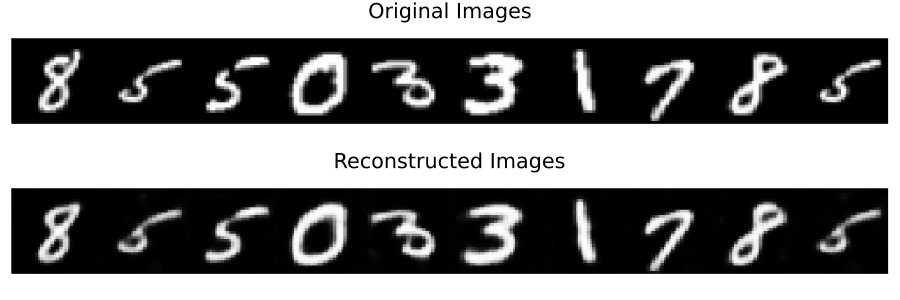

In [15]:
x = first(dtrn);

x_rec = m(x)

plot_reconstructed_images(Array{Float32}(x), Array{Float32}(x_rec))

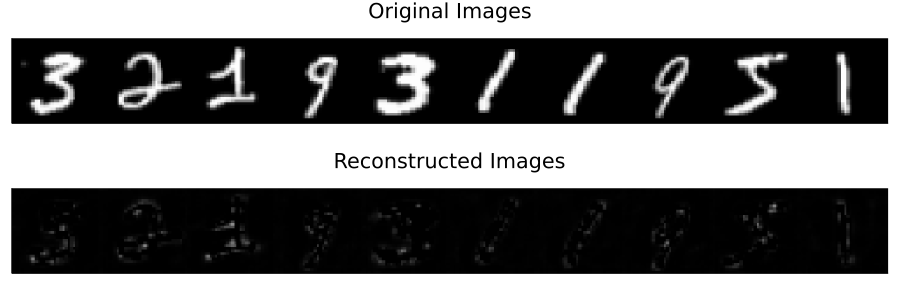

In [16]:
plot_reconstructed_images(Array{Float32}(x), Array{Float32}(x_rec- x))

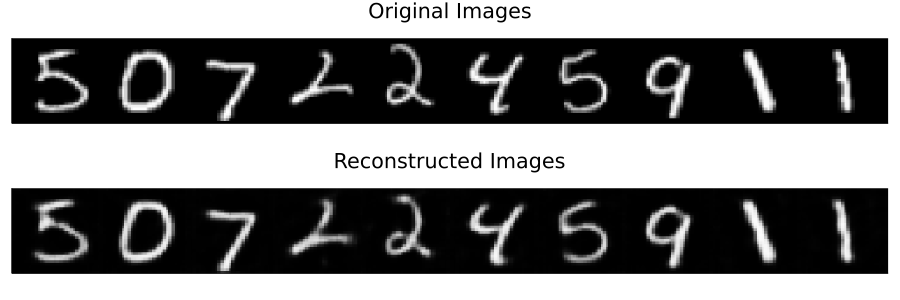

In [20]:
x = first(dtst);

x_rec = m(x)

plot_reconstructed_images(Array{Float32}(x), Array{Float32}(x_rec))

In [18]:
function plot_loss_convergence(trn_loss, tst_loss = nothing, figsize = (700, 500), epochs = nothing)
    if epochs == nothing
         epochs = 1:size(trn_loss,1)
    end    
    if tst_loss != nothing
        if size(trn_loss,1) != size(tst_loss,1)
            print("The loss vectors for train and test do not have the same size")
            return 0
        else
            plot(epochs,l_list ,label = "Train Loss", xlabel = "Epochs", ylabel = "Loss",
            title = "Train Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
            ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
            yguidefontsize=18, titlefontsize = 20, size = figsize)
            plot!(epochs,tst_l_list ,label = "Test Loss", title = "Train & Test Loss w.r.t. Epochs")
        end
    else
        plot(epochs,l_list ,label = "Train Loss", xlabel = "Epochs", ylabel = "Loss",
        title = "Train Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
        ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
        yguidefontsize=18, titlefontsize = 20, size = figsize)
    end
    
end

plot_loss_convergence (generic function with 4 methods)

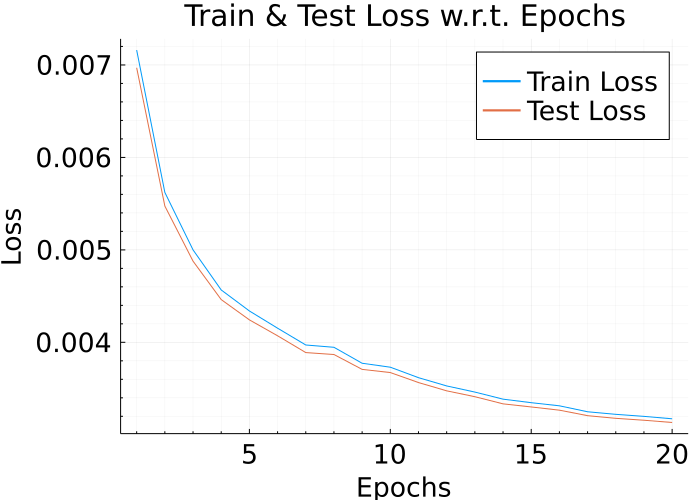

In [19]:
plot_loss_convergence(l_list, tst_l_list)